In [63]:
import time
import yaml
import os
import torch
import matplotlib.pyplot as plt
from utils.IO_func import read_file_list, load_binary_file, array_to_binary_file, load_Haskins_ATS_data
from shutil import copyfile
from utils.transforms import Pair_Transform_Compose
from utils.transforms import Fix_EMA_MissingValues_ATS, apply_delta_deltadelta_EMA_ATS, ProcrustesMatching_ATS, wav2melspec_ATS, change_wav_sampling_rate_ATS, ema_wav_length_match, padding_end, apply_EMA_MVN

In [64]:
import pickle
from database import HaskinsData_ATS
from torch.utils.data import Dataset, DataLoader
from utils.transforms import Pair_Transform_Compose
from utils.utils import prepare_Haskins_lists
from utils.transforms import padding_end, apply_EMA_MVN

In [65]:
def data_processing():

    '''
    Load in data from all speakers involved, apply feature extraction, 
    save them into binary files in the current_exp folder, 
    so that data loadin will be accelerated a lot.

    '''

    config_path = 'conf/ATS_conf.yaml'      
    config = yaml.load(open(config_path, 'r'), Loader=yaml.FullLoader)

    out_folder = os.path.join('current_exp', 'data')
    
    transforms = [Fix_EMA_MissingValues_ATS()] # default transforms
    data_path = config['corpus']['path']
    fileset_path = os.path.join(data_path, 'filesets')
    SPK_list = config['data_setup']['spk_list']
    ################ Articulatory data processing #################
    sel_sensors = config['articulatory_data']['sel_sensors']
    sel_dim = config['articulatory_data']['sel_dim']  
    procrustes = config['articulatory_data']['Procrustes']
    delta = config['articulatory_data']['delta']

    if procrustes == True:
        lateral = config['articulatory_data']['lateral']  
        transforms.append(ProcrustesMatching_ATS(sel_sensors, sel_dim, lateral = 'xz')) 
    if delta == True:
        transforms.append(apply_delta_deltadelta_EMA_ATS())
    ################ Acoustic data processing #################
    sampling_rate = config['acoustic_feature']['sampling_rate']
    filter_length = config['acoustic_feature']['filter_length']
    hop_length = config['acoustic_feature']['hop_length']
    win_length = config['acoustic_feature']['win_length']
    n_mel_channels = config['acoustic_feature']['n_mel_channels']
    mel_fmin = config['acoustic_feature']['mel_fmin']
    mel_fmax = config['acoustic_feature']['mel_fmax']

    transforms.append(change_wav_sampling_rate_ATS())
    transforms.append(wav2melspec_ATS(sampling_rate, filter_length, hop_length, win_length, 
                 n_mel_channels, mel_fmin, mel_fmax))
    transforms.append(ema_wav_length_match())

    transforms_all = Pair_Transform_Compose(transforms)
    
    for SPK in SPK_list:
        out_folder_SPK = os.path.join(out_folder, SPK)
        if not os.path.exists(out_folder_SPK):
            os.makedirs(out_folder_SPK)

        fileset_path_SPK = os.path.join(fileset_path, SPK)
        file_id_list = read_file_list(os.path.join(fileset_path_SPK, 'file_id_list.scp'))

        for file_id in file_id_list:
            data_path_spk = os.path.join(data_path, file_id[:3])
            mat_path = os.path.join(data_path_spk, 'data/'+ file_id + '.mat')
            EMA, WAV, fs_ema, fs_wav = load_Haskins_ATS_data(mat_path, file_id, sel_sensors, sel_dim)
            EMA, WAV = transforms_all(EMA, WAV) 
            EMA_out_dir = os.path.join(out_folder_SPK, file_id + '.ema')
            WAV_out_dir = os.path.join(out_folder_SPK, file_id + '.pt')
 #           array_to_binary_file(EMA, EMA_out_dir)
 #           torch.save(WAV, WAV_out_dir)
    return EMA, WAV

In [66]:
EMA, WAV = data_processing()

KeyboardInterrupt: 

In [ ]:
MSP = WAV.T

plt.figure(figsize=(20,4))
plt.imshow(MSP, origin='lower', cmap=plt.cm.hot, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title('mel-spectrogram (SD-ATS)')
plt.xlabel('time index')
plt.ylabel('frequency bin index')

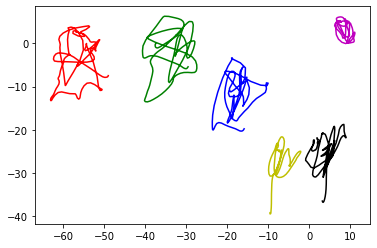

In [20]:
MV = EMA
plt.plot(MV[:,0], MV[:,2], 'r', MV[:,3], MV[:,5], 'g', MV[:,6], MV[:,8], 'b', MV[:,9], MV[:,11], 'm',  
         MV[:,12], MV[:,14], 'k',  MV[:,15], MV[:,17], 'y')

In [33]:
config = yaml.load(open('conf/ATS_conf.yaml', 'r'), Loader=yaml.FullLoader)

sel_sensors = config['articulatory_data']['sel_sensors']
sel_dim = config['articulatory_data']['sel_dim'] 
delta = config['articulatory_data']['delta']
d = 3 if delta == True else 1
ema_dim = len(sel_sensors)*len(sel_dim)*d

prepared_data_path = os.path.join('current_exp', 'data')
prepared_data_CV_path = os.path.join('current_exp', 'data_CV')

MVN = False
batch_size = config['training_setup']['batch_size']

train_transforms = []
valid_transforms = []
test_transforms = []

exp_train_lists = read_file_list('/home/beiming/Desktop/RAW_ATS_DATA/Haskins_IEEE/filesets/F01/test_id_list.scp')

i = 0

train_list = exp_train_lists


train_dataset = HaskinsData_ATS(prepared_data_path, train_list, ema_dim)
if MVN == True:
    EMA_mean, EMA_std = train_dataset.compute_ema_mean_std()
    train_transforms.append(apply_EMA_MVN(EMA_mean, EMA_std))


train_dataset = HaskinsData_ATS(prepared_data_path, train_list, ema_dim, transforms = Pair_Transform_Compose(train_transforms))


In [40]:
for file_id, ema, wav in train_dataset:
    EMA, WAV = ema, wav

In [ ]:
print(file_id)

Text(0, 0.5, 'frequency bin index')

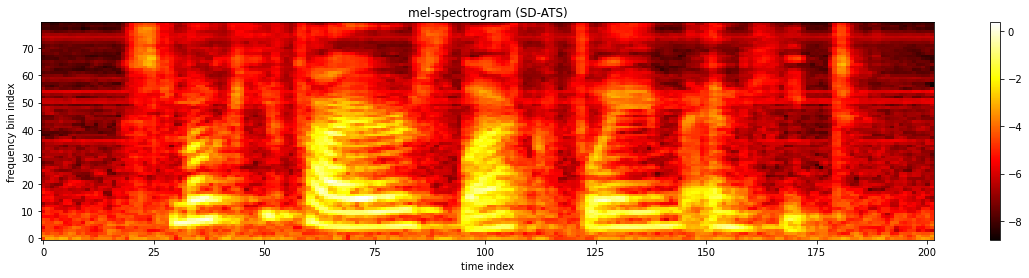

In [41]:
MSP = WAV.T

plt.figure(figsize=(20,4))
plt.imshow(MSP, origin='lower', cmap=plt.cm.hot, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title('mel-spectrogram (SD-ATS)')
plt.xlabel('time index')
plt.ylabel('frequency bin index')

In [42]:
print(WAV)

tensor([[-4.5578, -3.5672, -4.1713,  ..., -8.0662, -7.9302, -8.0878],
        [-3.2070, -3.6805, -4.5260,  ..., -8.0143, -7.8990, -8.0367],
        [-3.0821, -3.6095, -4.2106,  ..., -8.0770, -8.0822, -8.3025],
        ...,
        [-3.2426, -3.9122, -4.4073,  ..., -7.8800, -7.5315, -7.8502],
        [-3.3536, -3.9752, -4.3532,  ..., -8.0574, -7.9091, -8.0351],
        [-3.6982, -3.3354, -4.0370,  ..., -8.1655, -8.0409, -8.1746]])


In [43]:
wav = torch.load('/home/beiming/Desktop/website_samples/SI_ATS_Samples/SD_Z_Score/F01/F01_B01_S01_R01_F.pt')
print(wav)

tensor([[-3.9811, -3.6651, -3.6132,  ..., -3.5663, -3.5635, -3.5753],
        [-4.4230, -4.1580, -4.1125,  ..., -4.0610, -4.0561, -4.0714],
        [-4.9402, -4.6796, -4.6237,  ..., -4.5651, -4.5591, -4.5757],
        ...,
        [-8.0732, -7.9346, -7.8503,  ..., -7.8109, -7.7876, -7.8422],
        [-8.1317, -7.9840, -7.9142,  ..., -7.8847, -7.8618, -7.9152],
        [-8.1721, -8.0373, -8.0204,  ..., -8.0220, -7.9985, -8.0514]])


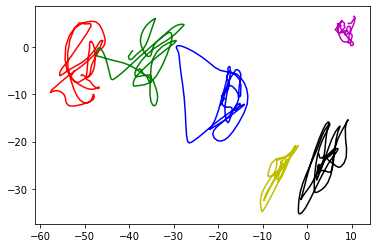

In [36]:
MV = EMA
plt.plot(MV[:,0], MV[:,2], 'r', MV[:,3], MV[:,5], 'g', MV[:,6], MV[:,8], 'b', MV[:,9], MV[:,11], 'm',  
         MV[:,12], MV[:,14], 'k',  MV[:,15], MV[:,17], 'y')

Text(0, 0.5, 'frequency bin index')

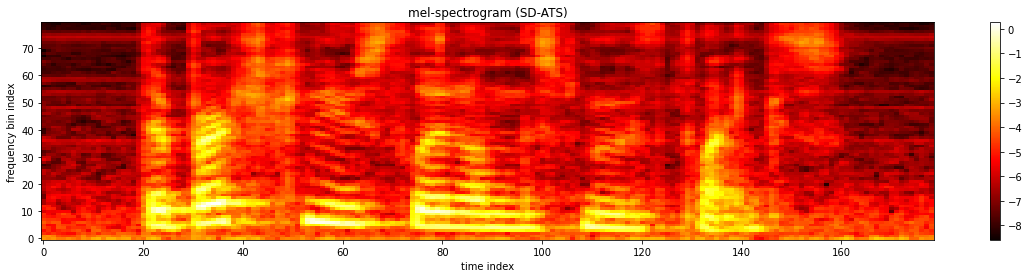

In [84]:
MSP = torch.load('/home/beiming/Desktop/ATS_Waveglow/current_exp/data/F01/F01_B01_S01_R01_F.pt').T

plt.figure(figsize=(20,4))
plt.imshow(MSP, origin='lower', cmap=plt.cm.hot, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title('mel-spectrogram (SD-ATS)')
plt.xlabel('time index')
plt.ylabel('frequency bin index')

Text(0, 0.5, 'frequency bin index')

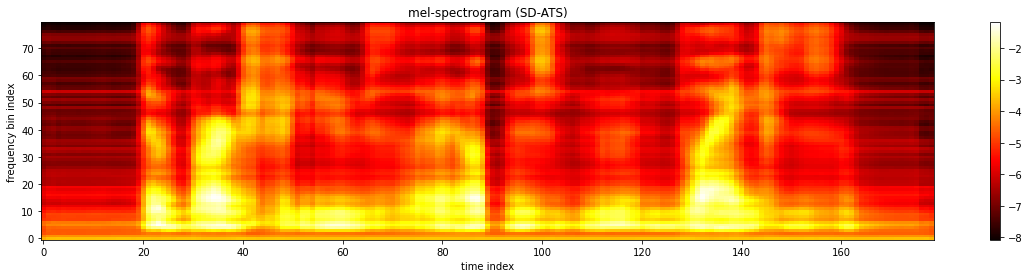

In [85]:
MSP_head = torch.load('/home/beiming/Desktop/ATS_Waveglow/current_exp/testing/F01/F01_B01_S01_R01_F.pt')

plt.figure(figsize=(20,4))
plt.imshow(MSP_head, origin='lower', cmap=plt.cm.hot, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title('mel-spectrogram (SD-ATS)')
plt.xlabel('time index')
plt.ylabel('frequency bin index')

In [86]:
class MCD(object):
    def __init__(self, n_mfcc=13):
        self.n_mfcc = n_mfcc

    def mcd(self, C, C_hat):
        """C and C_hat are NumPy arrays of shape (T, D),
        representing mel-cepstral coefficients.

        """
        K = 10 / np.log(10) * np.sqrt(2)
        return K * np.mean(np.sqrt(np.sum((C - C_hat) ** 2, axis=1)))

    def __call__(self, y_head, y):
        pred_log = np.log10((y_head.detach().cpu().numpy())**2)
        org_log = np.log10((y.detach().cpu().numpy())**2)
        mfccs_pred = librosa.feature.mfcc(S=pred_log.T,
                                         dct_type=2, n_mfcc=self.n_mfcc, norm='ortho', lifter=0)
        mfccs_org = librosa.feature.mfcc(S=org_log.T,
                                         dct_type=2, n_mfcc=self.n_mfcc, norm='ortho', lifter=0)

        mfcc_pred_T = mfccs_pred.T
        mfcc_org_T = mfccs_org.T
        MCD = self.mcd(mfcc_pred_T[:,1:12], mfcc_org_T[:,1:12])
        return MCD

In [87]:
metric = MCD()

In [88]:
print(metric(MSP, MSP_head))

8.431205633443316
